# Clasificación utilizando Naive Bayes

Este ejemplo está basado en el Libro Python Data Science Handbook de Jake VanderPlas

Los modelos Naive Bayes (Bayes Ingenuo) son un grupo de algoritmos de clasificación extremadamente rápidos y sencillos que suelen ser adecuados para conjuntos de datos de muy alta dimensión.

Al ser tan rápidos y tener tan pocos parámetros ajustables, acaban siendo útiles como referencia rápida y sucia para un problema de clasificación.

En este cuaderno se ofrece una explicación intuitiva del funcionamiento de los clasificadores Bayes ingenuos, seguida de algunos ejemplos de su funcionamiento en algunos conjuntos de datos.

## Clasificación Bayesiana

Los clasificadores Naive Bayes se basan en métodos de clasificación bayesianos.
Se basan en el teorema de Bayes, que es una ecuación que describe la relación de probabilidades condicionales de cantidades estadísticas.
En la clasificación bayesiana, nos interesa encontrar la probabilidad de una etiqueta $L$ dadas algunas características observadas, que podemos escribir como $P(L~|~{\rm features})$.

El teorema de Bayes nos dice cómo expresar esto en términos de cantidades que podemos calcular más directamente:

$$
P(L~|~{\rm features}) = \frac{P({\rm features}~|~L)P(L)}{P({\rm features})}
$$

Si intentamos decidir entre dos etiquetas -llamémoslas $L_1$ and $L_2$-entonces una forma de tomar esta decisión es calcular el cociente de las probabilidades posteriores para cada etiqueta:

$$
\frac{P(L_1~|~{\rm features})}{P(L_2~|~{\rm features})} = \frac{P({\rm features}~|~L_1)}{P({\rm features}~|~L_2)}\frac{P(L_1)}{P(L_2)}
$$

Todo lo que necesitamos ahora es algún modelo por el cual podamos calcular $P({\rm features}~|~L_i)$ para cada etiqueta.

Este modelo se denomina *modelo generativo* porque especifica el proceso aleatorio hipotético que genera los datos.
Especificar este modelo generativo para cada etiqueta es la pieza principal del entrenamiento de un clasificador bayesiano de este tipo.
La versión general de dicho paso de entrenamiento es una tarea muy difícil, pero podemos simplificarla mediante el uso de algunas suposiciones simplificadoras sobre la forma de este modelo.

Aquí es donde entra el "ingenuo" de "Bayes ingenuo": si hacemos suposiciones muy ingenuas sobre el modelo generativo para cada etiqueta, podemos encontrar una aproximación aproximada del modelo generativo para cada clase, y luego proceder con la clasificación bayesiana.
Los distintos tipos de clasificadores Bayes ingenuos se basan en distintas suposiciones ingenuas sobre los datos, y examinaremos algunas de ellas en las secciones siguientes.

Empezaremos con las importaciones estándar:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

<ipython-input-1-0907bc2e4194>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Bayes ingenuo gaussiano

Quizás el clasificador Bayes ingenuo más fácil de entender es el Bayes ingenuo gaussiano.
Con este clasificador, la suposición es que *los datos de cada etiqueta se extraen de una distribución gaussiana simple*.
Imaginemos que tenemos los siguientes datos:

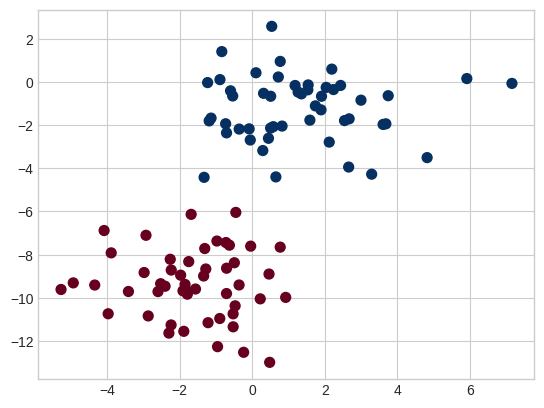

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

El modelo gaussiano más sencillo consiste en suponer que los datos se describen mediante una distribución gaussiana sin covarianza entre dimensiones. Este modelo puede ajustarse calculando la media y la desviación típica de los puntos dentro de cada etiqueta, que es todo lo que necesitamos para definir dicha distribución. El resultado de esta suposición gaussiana ingenua se muestra en la siguiente figura:

[(-8.0, 8.0), (-15.0, 5.0)]

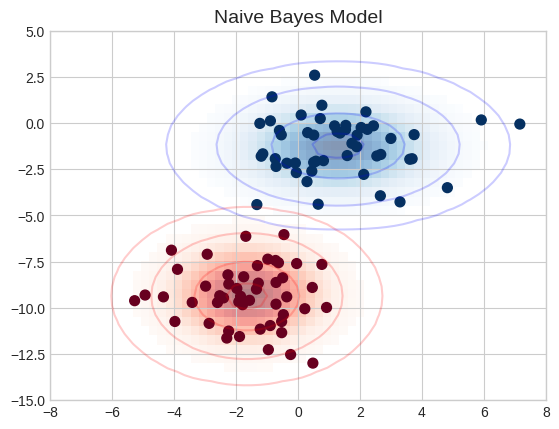

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(100, 2, centers=2, random_state=2, cluster_std=1.5)

fig, ax = plt.subplots()

ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
ax.set_title('Naive Bayes Model', size=14)

xlim = (-8, 8)
ylim = (-15, 5)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

for label, color in enumerate(['red', 'blue']):
    mask = (y == label)
    mu, std = X[mask].mean(0), X[mask].std(0)
    P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)

ax.set(xlim=xlim, ylim=ylim)

Las elipses representan el modelo generativo gaussiano para cada etiqueta, con una probabilidad mayor hacia el centro de las elipses. Con este modelo generativo para cada clase, tenemos una receta sencilla para calcular la probabilidad $P({\rm features}~|~L_1)$ para cualquier punto de datos, y así podemos calcular rápidamente la proporción posterior y determinar qué etiqueta es la más probable para un punto dado.

Este procedimiento se implementa en el estimador `sklearn.naive_bayes.GaussianNB` de Scikit-Learn:

In [4]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

Generemos nuevos datos y predigamos la etiqueta:

In [5]:
rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

Ahora podemos trazar estos nuevos datos para hacernos una idea de dónde está el límite de decisión (véase la siguiente figura):

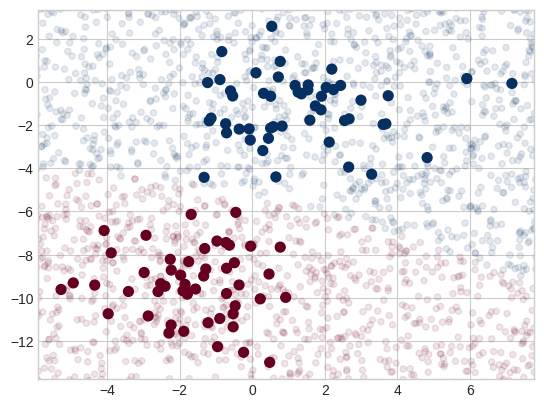

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

Vemos un límite ligeramente curvo en las clasificaciones; en general, el límite producido por un modelo Bayesiano ingenuo será cuadrático.

Un aspecto interesante de este formalismo bayesiano es que permite de forma natural la clasificación probabilística, que podemos calcular utilizando el método `predict_proba`:

In [7]:
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)

array([[0.89, 0.11],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.15, 0.85]])

Las columnas dan las probabilidades posteriores de la primera y segunda etiquetas, respectivamente.
Si busca estimaciones de la incertidumbre en su clasificación, los enfoques bayesianos como éste pueden ser un buen punto de partida.

Por supuesto, la clasificación final sólo será tan buena como las suposiciones del modelo que conducen a ella, por lo que el Bayes ingenuo gaussiano a menudo no produce muy buenos resultados.
Aun así, en muchos casos -especialmente cuando el número de características es elevado- esta suposición no es lo suficientemente perjudicial como para impedir que Gaussian naive Bayes sea un método fiable.

## Multinomial Naive Bayes

La hipótesis gaussiana que acabamos de describir no es, ni mucho menos, la única hipótesis sencilla que podría utilizarse para especificar la distribución generativa de cada etiqueta.
Otro ejemplo útil es el Bayes ingenuo multinomial, en el que se supone que las características se generan a partir de una distribución multinomial simple.
La distribución multinomial describe la probabilidad de observar recuentos entre una serie de categorías, por lo que el Bayes ingenuo multinomial es el más adecuado para las características que representan recuentos o tasas de recuento.

La idea es exactamente la misma que antes, salvo que en lugar de modelar la distribución de datos con la gaussiana de mejor ajuste, la modelamos con una distribución multinomial de mejor ajuste.

### Ejemplo: Clasificación de texto

Uno de los ámbitos en los que se suele utilizar el método Bayes ingenuo multinomial es en la clasificación de textos, donde las características están relacionadas con el recuento de palabras o las frecuencias dentro de los documentos que se van a clasificar.

Aquí utilizaremos las características de recuento de palabras dispersas del corpus 20 Newsgroups, disponible a través de Scikit-Learn, para mostrar cómo podemos clasificar estos documentos breves en categorías.

Descarguemos los datos y echemos un vistazo a los nombres objetivo:

In [13]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups()
print(data.keys())
data.target_names

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Para simplificar, seleccionaremos sólo algunas de estas categorías y descargaremos los conjuntos de entrenamiento y prueba:

In [14]:
categories = ['talk.religion.misc', 'soc.religion.christian',
              'sci.space', 'comp.graphics','rec.sport.baseball']
train = fetch_20newsgroups(subset='train', categories=categories)
test = fetch_20newsgroups(subset='test', categories=categories)

He aquí una entrada representativa de los datos:

In [15]:
train.data[0][0:]

"From: rytg7@fel.tno.nl (Q. van Rijt)\nSubject: Re: Sphere from 4 points?\nOrganization: TNO Physics and Electronics Laboratory\nLines: 26\n\nThere is another useful method based on Least Sqyares Estimation of the sphere equation parameters.\n\nThe points (x,y,z) on a spherical surface with radius R and center (a,b,c) can be written as \n\n   (x-a)^2 + (y-b)^2 + (z-c)^2 = R^2\n\nThis equation can be rewritten into the following form:  \n\n   2ax + 2by + 2cz + R^2 - a^2 - b^2 -c^2 = x^2 + y^2 + z^2\n\nApproximate the left hand part by   F(x,y,z) = p1.x + p2.x + p3.z + p4.1\n\nFor all datapoints, i.c. 4, determine the 4 parameters p1..p4 which minimise the average error |F(x,y,z) - x^2 - y^2 - z^2|^2.\n\nIn 'Numerical Recipes in C' can be found algorithms to solve these parameters.\n\nThe best fitting sphere will have \n- center (a,b,c) = (p1/2, p2/2, p3/2)\n- radius R = sqrt(p4 + a.a + b.b + c.c).\n\nSo, at last, will this solve you sphere estination problem, at least for the most situa

In [16]:
print(len(train.data))

2750


In [17]:
print(train.data[500])

From: steinly@topaz.ucsc.edu (Steinn Sigurdsson)
Subject: Re: Vandalizing the sky
Organization: Lick Observatory/UCO
Lines: 23
NNTP-Posting-Host: topaz.ucsc.edu
In-reply-to: flb@flb.optiplan.fi's message of Fri, 23 Apr 1993 12:01:38 GMT

In article <C5xr2w.Dnw.1@cs.cmu.edu> flb@flb.optiplan.fi ("F.Baube[tm]") writes:

   From: "Phil G. Fraering" <pgf@srl03.cacs.usl.edu>

   > Finally: this isn't the Bronze Age, [..]
   > please try to remember that there are more human activities than
   > those practiced by the Warrior Caste, the Farming Caste, and the
   > Priesthood.

   Right, the Profiting Caste is blessed by God, and may 
    freely blare its presence in the evening twilight ..

The Priesthood has never quite forgiven
the merchants (aka Profiting Caste [sic])
for their rise to power, has it?

;-)

*  Steinn Sigurdsson   			Lick Observatory      	*
*  steinly@lick.ucsc.edu 		"standard disclaimer"  	*
*  Ya know... you penguin types offend me. ...			*
*  My Gosh... Life is offensiv

Con el fin de utilizar estos datos para el aprendizaje automático, tenemos que ser capaces de convertir el contenido de cada cadena en un vector de números.
Para ello, utilizaremos el vectorizador TF-IDF, y crearemos un canal (pipeline) que lo conecte a un clasificador Bayes ingenuo multinomial:

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), MultinomialNB())

Con este proceso, podemos aplicar el modelo a los datos de entrenamiento y predecir las etiquetas de los datos de prueba:

In [19]:
model.fit(train.data, train.target)
labels = model.predict(test.data)

Ahora que hemos predicho las etiquetas de los datos de prueba, podemos evaluarlas para conocer el rendimiento del estimador.
Por ejemplo, echemos un vistazo a la matriz de confusión entre las etiquetas verdaderas y las predichas para los datos de prueba (véase la figura siguiente):

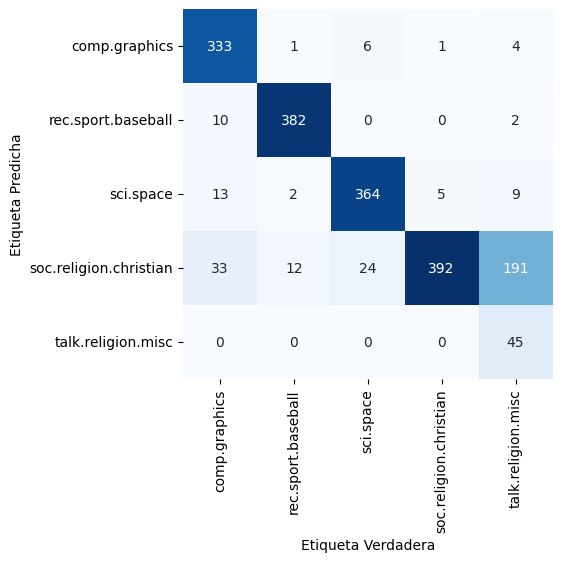

In [22]:
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(test.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=train.target_names, yticklabels=train.target_names,
            cmap='Blues')
plt.xlabel('Etiqueta Verdadera')
plt.ylabel('Etiqueta Predicha');

Evidentemente, incluso este clasificador tan simple puede separar con éxito las discusiones espaciales de las informáticas, pero se confunde entre las discusiones sobre religión y las discusiones sobre cristianismo.
Quizás era de esperar.

Lo bueno aquí es que ahora tenemos las herramientas para determinar la categoría de *cualquier* cadena, usando el método `predict` de este pipeline.
He aquí una función de utilidad que devolverá la predicción para una sola cadena:

In [23]:
def predict_category(s, train=train, model=model):
    pred = model.predict([s])
    return train.target_names[pred[0]]

Pongámosla a prueba:

In [32]:
predict_category('the pitcher was awesome!')

'rec.sport.baseball'

In [34]:
predict_category('The pope is visiting Mexico')

'soc.religion.christian'

In [38]:
predict_category('I think theres is life in Mars')

'sci.space'

Recuerde que no se trata de nada más sofisticado que un simple modelo de probabilidad para la frecuencia (ponderada) de cada palabra de la cadena; no obstante, el resultado es sorprendente.

Incluso un algoritmo muy ingenuo, cuando se utiliza con cuidado y se entrena con un gran conjunto de datos de alta dimensión, puede ser sorprendentemente eficaz.

## Cuándo utilizar Naive Bayes

Dado que los clasificadores Bayes ingenuos hacen suposiciones muy estrictas sobre los datos, no suelen funcionar tan bien como los modelos más complicados.
Dicho esto, tienen varias ventajas:

- Son rápidos tanto en el entrenamiento como en la predicción.
- Proporcionan una predicción probabilística directa.
- Suelen ser fáciles de interpretar.
- Tienen pocos (o ningún) parámetro ajustable.

Estas ventajas significan que un clasificador Bayes ingenuo es a menudo una buena opción como clasificación inicial de referencia.
Si funciona correctamente, enhorabuena: tiene un clasificador muy rápido y muy interpretable para su problema.
Si no funciona bien, puede empezar a explorar modelos más sofisticados, con un cierto conocimiento de referencia sobre su rendimiento.

Los clasificadores Bayes ingenuos tienden a funcionar especialmente bien en las siguientes situaciones:

- Cuando las suposiciones ingenuas coinciden realmente con los datos (muy raro en la práctica).
- Para categorías muy bien separadas, cuando la complejidad del modelo es menos importante.
- Para datos de muy alta dimensión, cuando la complejidad del modelo es menos importante.

Los dos últimos puntos parecen distintos, pero en realidad están relacionados: a medida que aumenta la dimensionalidad de un conjunto de datos, es mucho menos probable que dos puntos cualesquiera se encuentren próximos entre sí (después de todo, deben estar próximos en *cada una de las dimensiones* para estar próximos en conjunto).
Esto significa que los conglomerados en dimensiones altas tienden a estar más separados, por término medio, que los conglomerados en dimensiones bajas, suponiendo que las nuevas dimensiones realmente añadan información.
Por este motivo, los clasificadores simplistas, como los que se comentan aquí, tienden a funcionar tan bien o mejor que los clasificadores más complicados a medida que aumenta la dimensionalidad: una vez que se tienen suficientes datos, incluso un modelo simple puede ser muy potente.

# Realizando Traducción de español a inglés para usar el modelo

In [1]:
!pip install googletrans==3.1.0a0

In [2]:
from googletrans import Translator, constants

In [3]:
traductor = Translator()

In [40]:
texto = "El picher lanzó un partido excepcional"

Para consultar la lista de lenguajes soportados puede visitar el siguiente vínculo: [lenguajes soportados](https://py-googletrans.readthedocs.io/en/latest/#googletrans-languages).

In [41]:
traduccion = traductor.translate(texto, src="es", dest='en')

In [42]:
print(traduccion.text)

The pitcher pitched an exceptional game


In [43]:
predict_category(traduccion.text)

'rec.sport.baseball'